In [1]:
!pip install auto-sklearn

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split

def clean_input_csv (url):
    df = pd.read_csv(url,na_values='.') # The na_values setting replaces NaN/null values with a floating-point and string compatible dot
    #df = df.sample(frac=1, random_state=1).reset_index() #okay actuall test train split already shuffles so this line is redundant

    # Change non-numerical columns to 'category' a statistical-category datatype understood by scikit,etc
    cols = df.select_dtypes(include='object').columns
    #df[cols] = df[cols].fillna('MissingValues')
    df[cols] = df[cols].astype('category')

    # Remove columns that are due to contact with voters because that's a bias to prediction
    disallow=['mAddress','Address','PreferredEmail','VoterVolunteer','Volunteer_Ask','Notes','Heard_about_Rana?']
    df = df.drop(disallow, axis=1)

    # Drop columns where y is null from test/train set
    df_after_dropping = df.dropna(axis='index',subset=['Support_Rana?'])
    needs_predictions = df[~df.index.isin(df_after_dropping.index)]
    df = df_after_dropping

    #Cleanup NaN/null in numeric columns
    # select numeric columns
    numeric_columns = df.select_dtypes(exclude=['category']).columns

    # fill 0 to all NaN 
    df[numeric_columns] = df[numeric_columns].fillna('0').apply(pd.to_numeric)

    # Split out the target column
    y = df['Support_Rana?'].str.replace('[^0-9]','').apply(pd.to_numeric).replace(2,1).replace(3,0).replace(4,0).replace(5,0).astype('int64')
    X = df.drop('Support_Rana?',axis=1)
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)
    return X, y

#csvs
url_all_ids_may10 = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTMcVu8cf1ZEFK6yuHn3xgJrT5L5jTQa7GY9zuRaIvgyrYBpWL08iyAcvbWT9kyulrs1PT3u1HyrRGz/pub?gid=1976628524&single=true&output=csv'
url_all_phones_may3 = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTd1WpzujmHh-qYe19ddQPSWFnrdmHM6g0XvblVcAVAVhwgM91qQKM4Hyvvi58fSnoGpjcWcXG3FSr6/pub?gid=616038225&single=true&output=csv'

# Import all phones may 3
X, y = clean_input_csv(url_all_phones_may3)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=45)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: FutureWarning: The default value of regex will change from True to False in a future version.


In [3]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler 

print('Original dataset shape %s' % Counter(y_train))

rus = RandomOverSampler(random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)

print('Resampled dataset shape %s' % Counter(y_train))

Original dataset shape Counter({0: 660, 1: 513})
Resampled dataset shape Counter({1: 660, 0: 660})


In [25]:
from autosklearn.metrics import balanced_accuracy, precision, recall, f1

import autosklearn.classification
cls = autosklearn.classification.AutoSklearnClassifier(time_left_for_this_task=300)
cls.fit(X_train, y_train)
predictions = cls.predict(X_test)

/usr/local/lib/python3.7/dist-packages/autosklearn/data/feature_validator.py:209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = X[column].astype('category')
/usr/local/lib/python3.7/dist-packages/autosklearn/data/feature_validator.py:209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = X[column].astype('category')
/usr/local/lib/python3.7/dist-packages/autosklearn/data/feature_validator.py:209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


              precision    recall  f1-score   support

           0       0.67      0.69      0.68       297
           1       0.53      0.50      0.52       207

    accuracy                           0.62       504
   macro avg       0.60      0.60      0.60       504
weighted avg       0.61      0.62      0.61       504



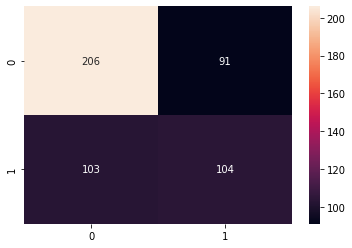

In [27]:
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predictions)
f = sns.heatmap(cm, annot=True, fmt='d')
print(classification_report(y_test, predictions))

In [26]:
cls.leaderboard()

,rank,ensemble_weight,type,cost,duration
model_id,,,,,
6,1,0.06,random_forest,0.373711,20.522794
30,2,0.04,random_forest,0.378866,3.194460
21,3,0.06,random_forest,0.386598,4.694791
31,4,0.06,random_forest,0.386598,2.789174
22,5,0.12,adaboost,0.391753,3.099954
28,6,0.02,random_forest,0.391753,3.405226
2,7,0.02,random_forest,0.394330,5.230498
10,8,0.08,random_forest,0.394330,4.659841
32,9,0.04,random_forest,0.394330,3.218745
